# Analysis of Alanine dipeptide with Umbrella sampling

## Relevant imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import simtk.openmm as mm
import simtk.openmm.app as app
from openmmtools.testsystems import AlanineDipeptideExplicit
import mdtraj as md

## Gathering the data

### Obtaining trajectory

In [2]:
import shutil

In [3]:
source_folder = r"C:\\Users\\nereu\\TFG_physics_final\\results\\"
name="alad-015M-15A-NOCHARMM-US-stray-filesalad-015M-15A-phi-"
destination_folder = "C:\\Users\\nereu\\TFG_physics_final\\results\\alad-015M-15A-run-NOCHARMM-US-stray-files\\"


# fetch all files
for file_name in os.listdir(source_folder):
    # construct full file path
    source = source_folder + file_name
    destination = destination_folder + file_name
    # move only files
    if name in file_name:
        shutil.move(source, destination)
        #print('Moved:', file_name)

In [4]:
# Set the directory path
directory = 'results/alad-015M-15A-run-NOCHARMM-US-3/'
name="alad-015M-15A"
# Get the list of all files in the directory
files = os.listdir(directory)
n_loops=100
traj=[[] for i in range(n_loops)]
# Iterate over all the files in the directory
for file in files:
    i=0
    # Check if the file has the ".chk" extension
    if file.endswith("coords.npy"):
        loop=int(file.split("loop-")[1].split("-coords")[0])
        i+=1
        traj[int(loop)].append(np.load(directory+file))

In [5]:
np.array(traj).shape

(100, 324, 2, 22, 3)

In [6]:
new_traj=[[] for window_traj in traj[0]]
for loop_traj in traj:
    for index,window_traj in enumerate(loop_traj):
        new_traj[index].append(window_traj)

In [7]:
np.array(traj[0][0]).shape

(2, 22, 3)

In [8]:
new_traj=np.array(new_traj)

In [9]:
new_traj.shape

(324, 100, 2, 22, 3)

In [10]:
#We reshape the trajectories as there are 50 snapshots in each np file
traj_mult=new_traj.reshape(324,-1,22,3)

### Obtaining topology

In [11]:
topology_default=AlanineDipeptideExplicit().topology

In [12]:
all_top=md.Topology.from_openmm(topology_default)
atom_list=[]
solute_top=md.Topology()
# Iterate over the chains in the original Topology
for chain in all_top.chains:
    # Create a new Chain object in the solute Topology
    solute_chain = solute_top.add_chain()
    # Iterate over the residues in the chain
    for residue in chain.residues:
        # If the residue is a solute (ALA) residue, add it to the solute Topology
        if residue.name != 'HOH':
            solute_top.add_residue(residue.name, solute_chain)
            #We append a list that will hold all the atoms of the same residue
            atom_list.append([])
            for atom in residue.atoms:
                #We append tha atoms to their corresponding last list
                atom_list[-1].append(atom)

#Putting atoms in their residues
solute_residue_list=[]
for residue in solute_top.residues:
    solute_residue_list.append(residue)
for indx, atom_group in enumerate(atom_list):
    for atom in atom_group:
        solute_top.add_atom(atom.name, atom.element, solute_residue_list[indx])
                

# Iterate over the bonds in the solute residues
for bond in all_top.bonds:
    # Get the atoms that are bonded
    atoms=bond
    # If both atoms are in the solute Topology, add the bond
    if atoms[0].residue.name != 'HOH' and atoms[1].residue.name != 'HOH':
        solute_top.add_bond(atoms[0], atoms[1])


### Computing dihedrals

In [13]:
import matplotlib as mpl
def make2dhist(traj, name):
    valphi=md.compute_phi(traj)[1]
    valpsi=md.compute_psi(traj)[1]
    histphi=np.array([value[0] for value in valphi])*180/(np.pi)
    histpsi=np.array([value[0] for value in valpsi])*180/(np.pi)
    h=plt.hist2d(histphi,histpsi, bins=100, norm=mpl.colors.LogNorm())[0]
    plt.xlabel("$\phi$")
    plt.ylabel("$\psi$")
    plt.title("2D histogram for "+str(name))

In [14]:
#Building trajectory
window_traj=[]
for traj in traj_mult:
    window_traj.append(md.Trajectory(traj, solute_top))

In [15]:
window_valphi=[]; window_valpsi=[]
for md_traj in window_traj:
    window_valphi.append(md.compute_phi(md_traj)[1].T[0])
    window_valpsi.append(md.compute_psi(md_traj)[1].T[0])
window_valpsi=np.array(window_valpsi)
window_valphi=np.array(window_valphi)

## Computing the energy matrix A

In [16]:
from simtk.openmm import unit
import FastMBAR

In [17]:
#Physical constants
T=298*unit.kelvin
kbT=(unit.BOLTZMANN_CONSTANT_kB*T*unit.AVOGADRO_CONSTANT_NA).value_in_unit(unit.kilojoule_per_mole)

In [18]:
#Computing the window ranges
n_windows=360//20; angle_step=20*np.pi/180
total_windows=n_windows*n_windows
window_samples=window_valphi.shape[1]

In [19]:
#Force constant of bias potential
K=131
#Load dihedrals of the bias potential
psi_bias=np.load('{}/{}-psi-bias.npy'.format(directory,name))
phi_bias=np.load('{}/{}-psi-bias.npy'.format(directory,name))

In [20]:
A=np.zeros((total_windows, total_windows*window_samples))

valpsi=np.reshape(window_valpsi, (-1,))
valphi=np.reshape(window_valphi, (-1,))

for index in range(total_windows):
    psi_index= index//n_windows
    phi_index=index%n_windows
    
    psi_c=psi_bias[psi_index]
    phi_c=phi_bias[phi_index]
    
    psi_diff=np.abs(valpsi-psi_c)
    psi_diff=np.minimum(psi_diff, 2*np.pi-psi_diff)

    phi_diff=np.abs(valphi-phi_c)
    phi_diff=np.minimum(phi_diff, 2*np.pi-phi_diff)
    
    A[index,:]=0.5*K*(psi_diff**2+phi_diff**2)/kbT

In [21]:
num_conf_all=np.array([window_samples for i in range(total_windows)])

In [22]:
fastmbar=FastMBAR.FastMBAR(energy=A, num_conf=num_conf_all,
                           cuda=False, verbose=True, bootstrap=True)

solve MBAR equation using CPU


## Compute Matrix B

In [23]:
#number of windows per dihedral
l_PMF=50
L_PMF=l_PMF*l_PMF

#We divide the angles in this sense
psi_PMF=np.linspace(-np.pi, np.pi, l_PMF, endpoint=False)
phi_PMF=np.linspace(-np.pi, np.pi, l_PMF, endpoint=False)
width=2*np.pi/l_PMF

B=np.zeros((L_PMF, A.shape[1]))

for index in range(L_PMF):
    psi_index=index//l_PMF
    phi_index=index%l_PMF
    
    psi_c_PMF=psi_PMF[psi_index]
    phi_c_PMF=phi_PMF[phi_index]
    
    psi_low=psi_c_PMF-0.5*width
    psi_high=psi_c_PMF+0.5*width

    phi_low=phi_c_PMF-0.5*width
    phi_high=phi_c_PMF+0.5*width
    
    psi_indicator=((valpsi > psi_low) & (valpsi <= psi_high)) | \
    ((valpsi + 2*np.pi > psi_low) & (valpsi + 2*np.pi <=psi_high)) | \
    ((valpsi - 2*np.pi > psi_low) & (valpsi - 2*np.pi <=psi_high))

    phi_indicator = ((valphi > phi_low) & (valphi <= phi_high)) | \
    ((valphi + 2*np.pi > phi_low) & (valphi + 2*np.pi <=phi_high)) | \
    ((valphi - 2*np.pi > phi_low) & (valphi - 2*np.pi <=phi_high))
     
    indicator=psi_indicator & phi_indicator
    B[index,~indicator]=np.inf
 

In [24]:
##Compute PMF using the energy matrix B
PMF, PMF_std=fastmbar.calculate_free_energies_of_perturbed_states(B)

C:\Users\nereu\anaconda3\envs\openmm2022\lib\site-packages\FastMBAR\fastmbar.py:272: RuntimeWarning: invalid value encountered in subtract
  F = -(np.log(np.mean(np.exp(tmp-np.max(tmp,1,keepdims=True)), 1)) + np.max(tmp, 1))


# Analyze data

In [25]:
import matplotlib as mpl
import seaborn as sns
import pandas as pd

In [26]:
sns.set()

## PMF projected on reaction coords.

In [27]:
#Take out NaN values
nanPMF=np.zeros(PMF.shape)
nanmax=np.nanmax(PMF)
for index,element in enumerate(PMF):
    nanPMF[index]=element
    if np.isnan(element):
        nanPMF[index]=nanmax

In [28]:
nanPMF-np.min(nanPMF)

array([5.46209794, 3.84019633, 2.84339636, ..., 9.66241304, 8.50401639,
       7.21586215])

In [29]:
dic={"$\psi$":np.array([psi_PMF[index//l_PMF] for index in range(L_PMF)])*180/np.pi,
    "$\phi$":np.array([psi_PMF[index%l_PMF] for index in range(L_PMF)],)*180/np.pi,
    "Free Energy": (nanPMF-np.min(nanPMF))}

In [30]:
df_F=pd.DataFrame(dic)

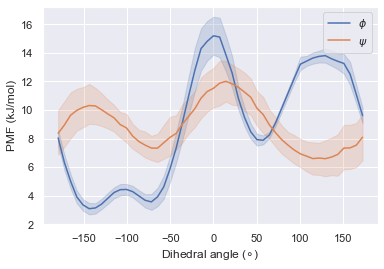

In [31]:
fig, ax=plt.subplots(1,1)
axis=sns.lineplot(data=df_F, x="$\phi$", y="Free Energy", ax=ax, label="$\phi$")
axis.set_ylabel("PMF (kJ/mol")
axis=sns.lineplot(data=df_F, x="$\psi$", y="Free Energy", ax=ax, label="$\psi$")
axis.set_ylabel("PMF (kJ/mol)")
axis.set_xlabel("Dihedral angle ($\circ$)")
ax.legend()

## PMF on both reaction coords.

In [32]:
def fmt_F(x, pos):
    a = '{:.1f}'.format(x)
    return r'${}$'.format(a)

In [33]:
free_energy_matrix=np.flipud(PMF.reshape((l_PMF, l_PMF)))

In [34]:
error_PMF=PMF_std/PMF*100

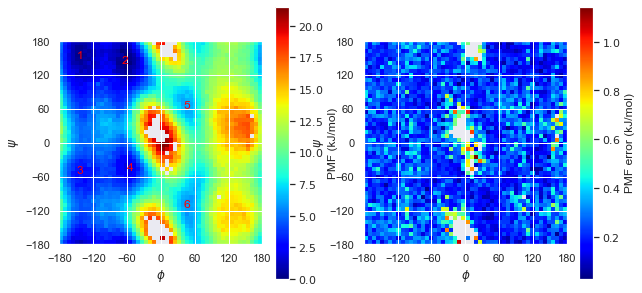

In [35]:
fig, axis = plt.subplots(1,2,figsize=(2*5, 5))
im=axis[0].imshow(np.flipud(PMF.reshape((l_PMF, l_PMF))-np.min(nanPMF)), extent = (-180, 180, -180, 180),
           cmap="jet")
axis[0].set_xlabel(r"$\phi$")
axis[0].set_ylabel(r"$\psi$")
cbar_F=plt.colorbar(im, format=mpl.ticker.FuncFormatter(fmt_F),
            ax=axis[0])
cbar_F.set_label("PMF (kJ/mol)")

im=axis[1].imshow(np.flipud(PMF_std.reshape((l_PMF, l_PMF))), extent = (-180, 180, -180, 180),
           cmap="jet")
axis[1].set_xlabel(r"$\phi$")
axis[1].set_ylabel(r"$\psi$")
cbar_F=plt.colorbar(im, format=mpl.ticker.FuncFormatter(fmt_F),
            ax=axis[1])
cbar_F.set_label("PMF error (kJ/mol)")







axis[0].text(-150, 150, s=r"1", color="red")
axis[0].text(-70, 140, s=r"2", color="red")
axis[0].text(-150, -55, s=r"3", color="red")
axis[0].text(-60, -50, s=r"4", color="red")

axis[0].text(40, 60, s=r"5", color="red")
axis[0].text(40, -115, s=r"6", color="red")

for ax in axis:
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(60))
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(60))

plt.show()


fig.tight_layout()



In [36]:
np.save('results/final-psi-US.npy',valpsi)

## Biased sample

In [37]:
dic={'$\phi$': np.array([valphi[i] for i in range(len(valphi[:200*18*18]))])*(180/np.pi),
     '$\psi$': np.array([valpsi[i] for i in range(len(valphi[:200*18*18]))])*(180/np.pi),
    'sample': [i//(200*18) for i in range(len(valphi[:200*18*18]))]}

In [39]:
df=pd.DataFrame(dic)

<Figure size 648x648 with 0 Axes>

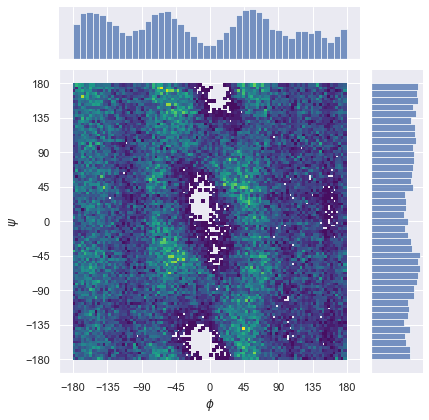

<Figure size 648x648 with 0 Axes>

In [40]:
from matplotlib import ticker
cmap=mpl.colors.Colormap("jet")
ax=sns.jointplot(data=df,
              x="$\phi$", y="$\psi$",
              kind="hist", cmap="viridis", cbar=False, bins=100
                )
ax.ax_joint.xaxis.set_major_locator(ticker.MultipleLocator(45))
ax.ax_joint.yaxis.set_major_locator(ticker.MultipleLocator(45))
plt.figure(figsize=(9,9))

### Time and Energy conservation

In [41]:
#We make a function to see the mean and avarage
def plot_mean_std(axis,X, array, color="blue", alpha=0.75, **kwargs):
    base=np.zeros(len(array));
    mean=base*0+np.mean(array);std=base*0+np.std(array)
    axis.plot(X,mean, color=color, alpha=alpha, **kwargs)
    axis.fill_between(X, mean-std, mean+std,
                   color=color, alpha=alpha*0.25, zorder=10)

In [42]:
data_scalars=pd.read_csv(directory+"alad-015M-15A-scalars-NOCHARMM-US-3.csv")
data_scalars

,"#""Time (ps)""",Potential Energy (kJ/mole),Total Energy (kJ/mole),Temperature (K),Speed (ns/day),Elapsed Time (s)
0,2.000000,-31683.565331,-26643.911698,266.724001,--,0.000983
1,4.000000,-30681.324462,-25275.159263,286.121650,31.3,5.524366
2,6.000000,-30177.051967,-24783.234233,285.468160,31.2,11.083462
3,8.000000,-30091.312473,-24506.107501,295.597342,31.1,16.668559
4,10.000000,-30066.447941,-24559.336405,291.464242,30.9,22.378730
...,...,...,...,...,...,...
6799,13600.000002,-29952.234031,-24167.232089,306.171610,26.2,44767.636103
6800,13602.000002,-30026.210213,-24351.263999,300.346903,26.2,44773.497839
6801,13604.000002,-29932.751065,-24123.512753,307.454321,26.2,44779.400543
6802,13606.000002,-29978.032687,-24339.232029,298.433897,26.2,44785.791721


In [43]:
#Getting equilibration umbrella jumps out of the plot
t=data_scalars['#"Time (ps)"']; T=data_scalars['Temperature (K)']; E=data_scalars['Total Energy (kJ/mole)']

new_t=[]; new_E=[]; new_T=[];

for index,temps in enumerate(t):
    if index%21!=0:
        new_T.append(T[index]);
        new_E.append(E[index]);
        new_t.append(t[index])

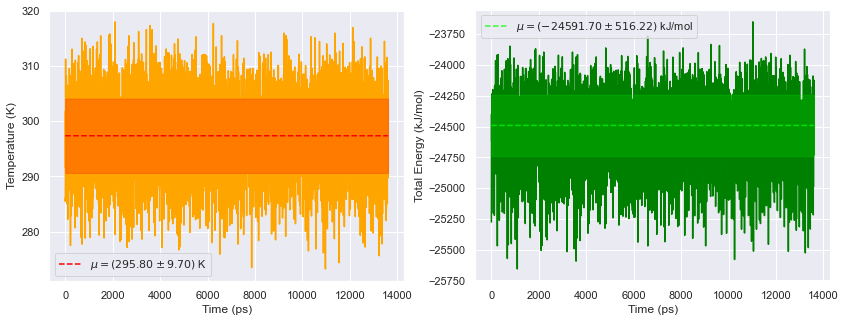

In [44]:
fig, axis=plt.subplots(1,2,figsize=(2*7,5))
axis[0].plot(new_t,new_T,color="orange", zorder=1)
plot_mean_std(axis[0],new_t, new_T, color="red", alpha=1,
             label=f"$\mu=({np.mean(T):.2f}\pm{np.std(T):.2f})$ K",
             linestyle="--", zorder=10)
axis[1].plot(new_t,new_E,color="green", zorder=1)
plot_mean_std(axis[1],new_t, new_E, color="lime", alpha=0.75,
             label=f"$\mu=({np.mean(E):.2f}\pm{np.std(E):.2f})$ kJ/mol",
             linestyle="--")
axis[1].set_xlabel("Time (ps)"); axis[0].set_ylabel("Temperature (K)")
axis[0].set_xlabel("Time (ps)"); axis[1].set_ylabel("Total Energy (kJ/mol)")
axis[1].legend(); axis[0].legend()